In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH="/mnt/Archivos/dataset-xray"

In [3]:
from pathlib import Path
from covidframe.tools.load import load_database_from_hdf

In [4]:
base_dir = Path(BASE_PATH)
DEFAULT_DATABASE_NAME_TRAIN = "database_balanced_train.h5"
DEFAULT_DATABASE_NAME_TEST = "database_balanced_test.h5"

In [5]:
df_train = load_database_from_hdf(filename= base_dir / DEFAULT_DATABASE_NAME_TRAIN)

In [6]:
df_train.head()

,image_path,image_name,original_category,id,type,source,folder_name,cv_hash,im_hash,original_image_path,original_image_name,category,size,is_squared,aspect_ratio,resized,new_size
0,/mnt/Archivos/dataset-xray/database_clean/COVI...,COVID-19_Radiography_Dataset_COVID-2966.png,COVID,COVID-2966,folders-metadata,kaggle,COVID-19_Radiography_Dataset,2525194807696518223,e5c2d8279f7ba482dfc3fab7049fd9290be29f89edad1d...,/mnt/Archivos/dataset-xray/COVID-19_Radiograph...,COVID-2966.png,covid-19,"(299, 299)",True,1.0,"[[58, 74, 67, 51, 35, 21, 15, 10, 8, 9, 9, 7, ...","(299, 299)"
1,/mnt/Archivos/dataset-xray/database_clean/COVI...,COVID-19_Radiography_Dataset_Lung_Opacity-2667...,Lung_Opacity,Lung_Opacity-2667,folders-metadata,kaggle,COVID-19_Radiography_Dataset,1085137777431229004,7fb1a436ffccd49f8c21821317dad08899d01f70981ed8...,/mnt/Archivos/dataset-xray/COVID-19_Radiograph...,Lung_Opacity-2667.png,pneumonia,"(299, 299)",True,1.0,"[[11, 25, 27, 26, 26, 27, 27, 26, 26, 26, 26, ...","(299, 299)"
2,/mnt/Archivos/dataset-xray/database_clean/COVI...,COVID-19_Radiography_Dataset_Lung_Opacity-5383...,Lung_Opacity,Lung_Opacity-5383,folders-metadata,kaggle,COVID-19_Radiography_Dataset,1082842259636424524,fc2d0e2eea7b55c37a2a9535d4bcc713c1b3b1c21b4068...,/mnt/Archivos/dataset-xray/COVID-19_Radiograph...,Lung_Opacity-5383.png,pneumonia,"(299, 299)",True,1.0,"[[165, 157, 148, 142, 136, 130, 125, 120, 118,...","(299, 299)"
3,/mnt/Archivos/dataset-xray/database_clean/COVI...,COVID-19_Radiography_Dataset_COVID-2346.png,COVID,COVID-2346,folders-metadata,kaggle,COVID-19_Radiography_Dataset,2167979743500276055,bfc280a462368db1679ce543ae8bbc7adefce20cc2a0d2...,/mnt/Archivos/dataset-xray/COVID-19_Radiograph...,COVID-2346.png,covid-19,"(299, 299)",True,1.0,"[[99, 86, 72, 59, 48, 39, 33, 28, 26, 28, 32, ...","(299, 299)"
4,/mnt/Archivos/dataset-xray/database_clean/COVI...,COVID-19_Radiography_Dataset_COVID-281.png,COVID,COVID-281,folders-metadata,kaggle,COVID-19_Radiography_Dataset,508639633549896718,d5d8833251de76f38f09fc8dd1dcace5bfdf2e13a79a45...,/mnt/Archivos/dataset-xray/COVID-19_Radiograph...,COVID-281.png,covid-19,"(299, 299)",True,1.0,"[[217, 216, 215, 215, 217, 219, 218, 217, 218,...","(299, 299)"


In [7]:
import numpy as np

In [8]:
X = df_train["resized"]

In [9]:
X.shape

(9732,)

In [10]:
category_mappings = {
    "normal":0,
    "pneumonia":1,
    "covid-19":2
}

In [11]:
y = df_train["category"].map(category_mappings)

In [12]:
y

0       2
1       1
2       1
3       2
4       2
       ..
9727    1
9728    2
9729    2
9730    0
9731    0
Name: category, Length: 9732, dtype: int64

In [13]:
import gc
del df_train
gc.collect()

0

In [14]:
from covidframe.preprocess.equalization import apply_equalization

In [15]:
X_eq_simple = X.apply(lambda x: apply_equalization(x, "simple"))

In [17]:
X_eq_clahe = X.apply(lambda x: apply_equalization(x))

In [23]:
X_eq_simple = np.stack(X_eq_simple)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_eq_simple, y, test_size=0.25, random_state=100)

In [26]:
X_train = X_train.reshape((-1, 299, 299, 1))
X_val = X_val.reshape((-1, 299, 299, 1))

In [27]:
X_train.shape

(7299, 299, 299, 1)

In [28]:
X_val.shape

(2433, 299, 299, 1)

In [33]:
IMG_SIZE=(299,299)
batch_size=10

In [34]:
import tensorflow as tf

In [35]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = dataset_train.shuffle(len(X_train))
#dataset_train = dataset_train.map(parse_function, num_parallel_calls=4)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(1)

2021-12-14 21:55:28.867855: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 652537899 exceeds 10% of free system memory.


In [36]:
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
dataset_val = dataset_val.shuffle(len(X_val))
#dataset_val = dataset_val.map(parse_function, num_parallel_calls=4)
dataset_val = dataset_val.batch(batch_size)
dataset_val = dataset_val.prefetch(1)

2021-12-14 21:55:32.273036: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 217512633 exceeds 10% of free system memory.


In [37]:
from tensorflow.keras import backend as K
import tensorflow as tf

tf.random.set_seed(0)

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, ReLU, Flatten, Dense, Rescaling
from tensorflow.keras.optimizers import SGD

def create_model():
    K.clear_session()

    input_layer = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    rescaling_layer = Rescaling(scale=1 / 127.5, offset=-1)(input_layer)
    convolutional_1 = Conv2D(16, kernel_size=3, padding="same")(rescaling_layer)
    max_pooling_1 = MaxPool2D(2)(convolutional_1)
    relu_1 = ReLU()(max_pooling_1)
    convolutional_2 = Conv2D(32, kernel_size=3, padding="same")(relu_1)
    max_pooling_2 = MaxPool2D(2)(convolutional_2)
    relu_2 = ReLU()(max_pooling_2)
    convolutional_3 = Conv2D(64, kernel_size=3)(relu_2)
    relu_3 = ReLU()(convolutional_3)
    flatten = Flatten()(relu_3)
    dense = Dense(256, activation="relu")(flatten)
    output_layer = Dense(3, activation="softmax")(dense)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [39]:
next(iter(dataset_val))

2021-12-14 21:55:46.768048: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 217512633 exceeds 10% of free system memory.


(<tf.Tensor: shape=(10, 299, 299, 1), dtype=uint8, numpy=
 array([[[[  4],
          [  4],
          [  4],
          ...,
          [  4],
          [  4],
          [  4]],
 
         [[  4],
          [  4],
          [  4],
          ...,
          [  4],
          [  4],
          [  4]],
 
         [[  4],
          [  4],
          [  4],
          ...,
          [  4],
          [  4],
          [  4]],
 
         ...,
 
         [[ 11],
          [ 17],
          [ 23],
          ...,
          [ 77],
          [138],
          [188]],
 
         [[ 18],
          [ 25],
          [ 24],
          ...,
          [ 80],
          [143],
          [191]],
 
         [[ 23],
          [ 17],
          [ 13],
          ...,
          [ 82],
          [147],
          [197]]],
 
 
        [[[248],
          [242],
          [239],
          ...,
          [146],
          [145],
          [137]],
 
         [[236],
          [233],
          [220],
          ...,
          [ 37],


In [40]:
lr = 0.001
momentum = 0.9

model = create_model()

2021-12-14 21:56:14.173839: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 339738624 exceeds 10% of free system memory.


In [41]:
model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 149, 149, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 32)      4640      
                                                             

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "my_model_eq_simple/model"

monitor = "val_accuracy"

mode = "max"

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=True, mode=mode)

In [46]:
batch_size

10

In [47]:
epochs = 5

history = model.fit(dataset_train, batch_size=batch_size, epochs=epochs, validation_data=dataset_val, callbacks=[model_checkpoint])

Epoch 1/5
730/730 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.6384
Epoch 00001: val_accuracy improved from -inf to 0.72585, saving model to my_model_eq_simple/model
730/730 [==============================] - 369s 501ms/step - loss: 0.8181 - accuracy: 0.6384 - val_loss: 0.6863 - val_accuracy: 0.7259
Epoch 2/5
730/730 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.7561
Epoch 00002: val_accuracy improved from 0.72585 to 0.77600, saving model to my_model_eq_simple/model
730/730 [==============================] - 393s 538ms/step - loss: 0.6177 - accuracy: 0.7561 - val_loss: 0.5692 - val_accuracy: 0.7760
Epoch 3/5
730/730 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.8000
Epoch 00003: val_accuracy did not improve from 0.77600
730/730 [==============================] - 378s 517ms/step - loss: 0.5017 - accuracy: 0.8000 - val_loss: 0.6241 - val_accuracy: 0.7645
Epoch 4/5
730/730 [==============================] - ETA

In [48]:
import matplotlib.pyplot as plt

In [49]:
def show_results(log):
    val_loss = log.history['val_loss']
    val_acc = log.history['val_accuracy']
      
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

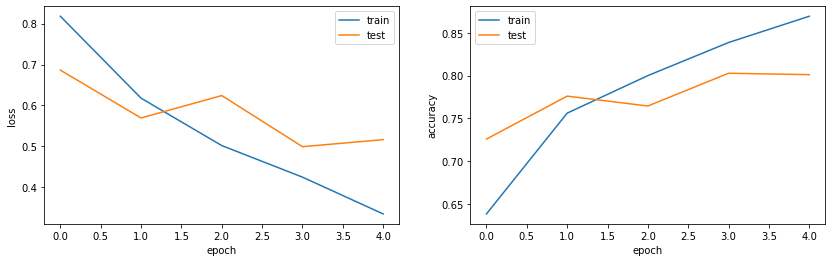

In [50]:
show_results(history)

In [51]:
model = create_model()

model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [52]:
model.load_weights(checkpoint_path)

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "my_model_eq_simple/model"

monitor = "val_accuracy"

mode = "max"

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=True, mode=mode)

In [55]:
epochs = 20

history = model.fit(dataset_train, batch_size=batch_size, epochs=epochs, validation_data=dataset_val, callbacks=[model_checkpoint])

Epoch 1/20
730/730 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8771
Epoch 00001: val_accuracy improved from -inf to 0.81874, saving model to my_model_eq_simple/model
730/730 [==============================] - 386s 525ms/step - loss: 0.3321 - accuracy: 0.8771 - val_loss: 0.5020 - val_accuracy: 0.8187
Epoch 2/20
730/730 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.9082
Epoch 00002: val_accuracy did not improve from 0.81874
730/730 [==============================] - 378s 517ms/step - loss: 0.2469 - accuracy: 0.9082 - val_loss: 0.5967 - val_accuracy: 0.8015
Epoch 3/20
730/730 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9340
Epoch 00003: val_accuracy improved from 0.81874 to 0.82450, saving model to my_model_eq_simple/model
730/730 [==============================] - 393s 538ms/step - loss: 0.1773 - accuracy: 0.9340 - val_loss: 0.5477 - val_accuracy: 0.8245
Epoch 4/20
730/730 [==============================] -

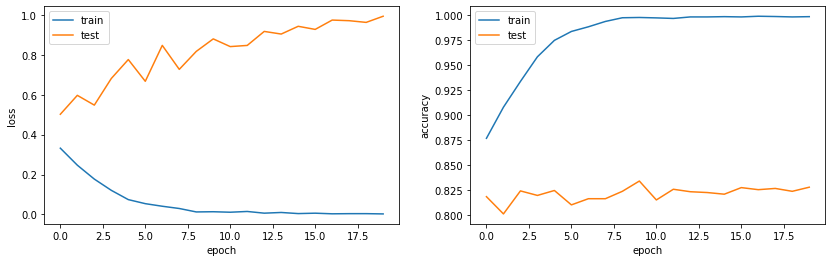

In [56]:
show_results(history)

## Metrics

In [57]:
df_test = load_database_from_hdf(filename= base_dir / DEFAULT_DATABASE_NAME_TEST)

In [74]:
X_test = df_test["resized"]

In [75]:
X_test_eq_simple = X_test.apply(lambda x: apply_equalization(x, "simple"))

In [76]:
X_test_eq_simple=np.stack(X_test_eq_simple)

In [59]:
y_test = df_test["category"].map(category_mappings)

In [77]:
X_test_eq_simple

array([[[  3,   3,   2, ..., 175, 224, 255],
        [  2,   1,   1, ...,  88, 137, 253],
        [  2,   1,   0, ...,  33,  88, 202],
        ...,
        [  1,   1,   0, ..., 104, 144, 173],
        [  1,   1,   1, ..., 107, 150, 175],
        [  2,   2,   2, ..., 110, 155, 175]],

       [[143, 132, 119, ..., 252, 252, 226],
        [ 55,  45,  35, ..., 231, 235, 201],
        [ 21,  17,  10, ..., 199, 209, 187],
        ...,
        [ 28,  36,  43, ...,  61, 115, 149],
        [ 35,  43,  48, ...,  61, 118, 152],
        [ 43,  50,  56, ...,  60, 121, 153]],

       [[  7,   6,   6, ..., 231, 221, 166],
        [  8,   7,   9, ..., 226, 219, 188],
        [  7,   7,   8, ..., 224, 213, 184],
        ...,
        [226, 237, 239, ..., 195, 153, 108],
        [239, 246, 243, ..., 199, 166, 108],
        [248, 249, 249, ..., 184, 137, 103]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   2,   2,   4],
        [  2,   2,   2, ...,   4,   4,   5

In [61]:
y_test

0       0
1       1
2       2
3       2
4       2
       ..
2428    2
2429    0
2430    2
2431    2
2432    1
Name: category, Length: 2433, dtype: int64

In [78]:
y_pred = model.predict(X_test_eq_simple)

In [79]:
y_pred.shape

(2433, 3)

In [80]:
y_pred_classes = np.argmax(y_pred, axis = 1)

In [81]:
y_pred_classes

array([0, 2, 2, ..., 2, 0, 1])

In [82]:
from sklearn.metrics import confusion_matrix

In [83]:
matrix = confusion_matrix(y_test, y_pred_classes)

In [84]:
matrix

array([[674,  82,  55],
       [110, 641,  60],
       [ 44,  35, 732]])

In [85]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

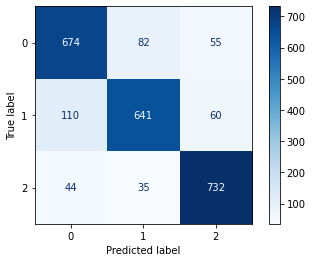

In [87]:
#requires scikit-learn 1.0
#otherwise use plot_confusion_matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, cmap=plt.cm.Blues)

In [88]:
matrix = confusion_matrix(y_test, y_pred_classes)
matrix = matrix.astype('float')
print(matrix)

class_acc = [matrix[i,i]/np.sum(matrix[i,:]) if np.sum(matrix[i,:]) else 0 for i in range(len(matrix))]
class_acc

[[674.  82.  55.]
 [110. 641.  60.]
 [ 44.  35. 732.]]


[0.8310727496917386, 0.7903822441430333, 0.9025893958076449]

## Training with CLAHE

In [37]:
from covidframe.ml.simple_model import create_model, compile_model, train_model
from covidframe.ml.checkpoint import create_checkpoint
from covidframe.ml.dataset import get_dataset_from_slices

In [22]:
from sklearn.model_selection import train_test_split

In [19]:
X_eq_cahe.shape

(9732,)

In [20]:
X_eq_cahe = np.stack(X_eq_cahe)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_eq_cahe, y, test_size=0.25, random_state=100)

In [24]:
X_train = X_train.reshape((-1, 299, 299, 1))
X_val = X_val.reshape((-1, 299, 299, 1))

In [25]:
dataset_train = get_dataset_from_slices(X_train, y_train,10)

2021-12-15 11:19:13.197146: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-15 11:19:13.197199: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luighiv): /proc/driver/nvidia/version does not exist
2021-12-15 11:19:13.212305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-15 11:19:13.291782: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 652537899 exceeds 10% of free system memory.


In [26]:
dataset_val = get_dataset_from_slices(X_val, y_val,10)

2021-12-15 11:19:14.372726: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 217512633 exceeds 10% of free system memory.


In [28]:
model = create_model()
model = compile_model(model, 0.001, 0.009)
checkpoint = create_checkpoint(checkpoint_path="my_model_eq_clahe/model")

In [30]:
history = train_model(model, dataset_train, dataset_val,model_checkpoint=checkpoint)

Epoch 1/5
730/730 [==============================] - ETA: 0s - loss: 0.8809 - accuracy: 0.6028
Epoch 00001: val_accuracy improved from -inf to 0.68434, saving model to my_model_eq_clahe/model
730/730 [==============================] - 413s 561ms/step - loss: 0.8809 - accuracy: 0.6028 - val_loss: 0.7663 - val_accuracy: 0.6843
Epoch 2/5
730/730 [==============================] - ETA: 0s - loss: 0.7602 - accuracy: 0.6805
Epoch 00002: val_accuracy improved from 0.68434 to 0.69749, saving model to my_model_eq_clahe/model
730/730 [==============================] - 401s 549ms/step - loss: 0.7602 - accuracy: 0.6805 - val_loss: 0.7435 - val_accuracy: 0.6975
Epoch 3/5
730/730 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.7002
Epoch 00003: val_accuracy improved from 0.69749 to 0.71476, saving model to my_model_eq_clahe/model
730/730 [==============================] - 398s 545ms/step - loss: 0.7094 - accuracy: 0.7002 - val_loss: 0.7100 - val_accuracy: 0.7148
Epoch 4/5
730

In [32]:
from covidframe.plot.metrics import show_results_from_history

(array([<AxesSubplot:xlabel='epoch', ylabel='loss'>,
        <AxesSubplot:xlabel='epoch', ylabel='accuracy'>], dtype=object),
 <Figure size 1008x288 with 2 Axes>)

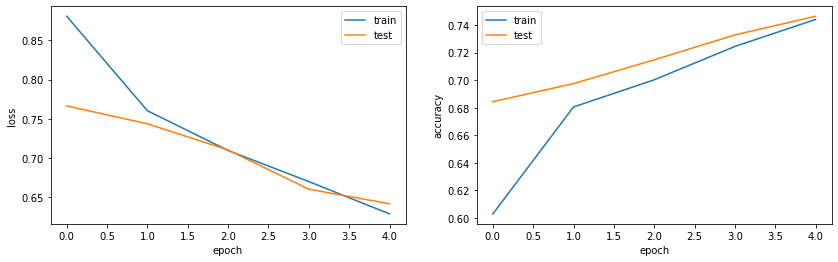

In [33]:
show_results_from_history(history)

In [43]:
from covidframe.ml.simple_model import load_weights
from tensorflow.keras.optimizers import SGD

In [45]:
lr=0.001
momentum = 0.9
model = create_model()

model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.load_weights("my_model_eq_clahe/model")

In [47]:
history = train_model(model, dataset_train, dataset_val, epochs=20)

Epoch 1/20
730/730 [==============================] - 432s 546ms/step - loss: 0.5962 - accuracy: 0.7626 - val_loss: 0.6064 - val_accuracy: 0.7550
Epoch 2/20
730/730 [==============================] - 376s 512ms/step - loss: 0.5686 - accuracy: 0.7734 - val_loss: 0.5977 - val_accuracy: 0.7591
Epoch 3/20
730/730 [==============================] - 375s 513ms/step - loss: 0.5383 - accuracy: 0.7850 - val_loss: 0.6417 - val_accuracy: 0.7427
Epoch 4/20
730/730 [==============================] - 402s 547ms/step - loss: 0.5187 - accuracy: 0.7926 - val_loss: 0.6025 - val_accuracy: 0.7616
Epoch 5/20
730/730 [==============================] - 404s 553ms/step - loss: 0.4948 - accuracy: 0.8035 - val_loss: 0.5720 - val_accuracy: 0.7772
Epoch 6/20
730/730 [==============================] - 402s 550ms/step - loss: 0.4681 - accuracy: 0.8164 - val_loss: 0.5583 - val_accuracy: 0.7879
Epoch 7/20
730/730 [==============================] - 375s 513ms/step - loss: 0.4471 - accuracy: 0.8260 - val_loss: 0.6196 -

2021-12-15 13:49:31.600779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 315 of 2433
2021-12-15 13:49:41.701345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 683 of 2433
2021-12-15 13:49:51.557915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1166 of 2433
2021-12-15 13:50:01.503176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1611 of 2433
2021-12-15 13:50:09.281923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


730/730 [==============================] - 464s 636ms/step - loss: 0.3315 - accuracy: 0.8766 - val_loss: 0.7085 - val_accuracy: 0.7497
Epoch 14/20
730/730 [==============================] - 407s 557ms/step - loss: 0.3085 - accuracy: 0.8871 - val_loss: 0.6249 - val_accuracy: 0.7764
Epoch 15/20
730/730 [==============================] - 385s 527ms/step - loss: 0.2965 - accuracy: 0.8868 - val_loss: 0.5131 - val_accuracy: 0.8118
Epoch 16/20
730/730 [==============================] - 401s 549ms/step - loss: 0.2733 - accuracy: 0.8975 - val_loss: 0.5753 - val_accuracy: 0.7970
Epoch 17/20
730/730 [==============================] - 407s 556ms/step - loss: 0.2613 - accuracy: 0.9022 - val_loss: 0.5387 - val_accuracy: 0.8035
Epoch 18/20
730/730 [==============================] - 408s 559ms/step - loss: 0.2400 - accuracy: 0.9104 - val_loss: 0.6336 - val_accuracy: 0.7818
Epoch 19/20
730/730 [==============================] - 388s 531ms/step - loss: 0.2192 - accuracy: 0.9197 - val_loss: 0.6250 - val_

(array([<AxesSubplot:xlabel='epoch', ylabel='loss'>,
        <AxesSubplot:xlabel='epoch', ylabel='accuracy'>], dtype=object),
 <Figure size 1008x288 with 2 Axes>)

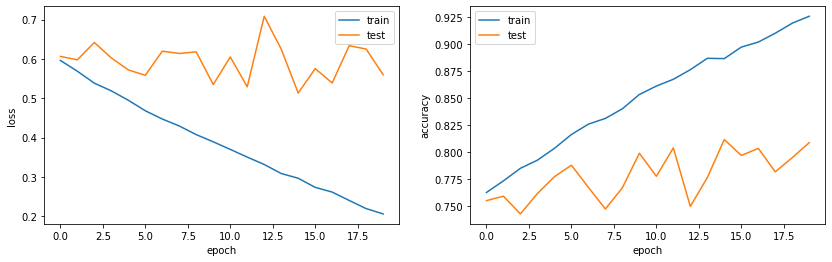

In [48]:
show_results_from_history(history)

In [49]:
history2 = train_model(model, dataset_train, dataset_val, epochs=10)

Epoch 1/10
730/730 [==============================] - 412s 562ms/step - loss: 0.1875 - accuracy: 0.9326 - val_loss: 0.5732 - val_accuracy: 0.8085
Epoch 2/10
730/730 [==============================] - 405s 555ms/step - loss: 0.1696 - accuracy: 0.9404 - val_loss: 0.5765 - val_accuracy: 0.8109
Epoch 3/10
730/730 [==============================] - 387s 530ms/step - loss: 0.1463 - accuracy: 0.9499 - val_loss: 0.6303 - val_accuracy: 0.8109
Epoch 4/10
730/730 [==============================] - 392s 536ms/step - loss: 0.1446 - accuracy: 0.9503 - val_loss: 1.0748 - val_accuracy: 0.7205
Epoch 5/10
730/730 [==============================] - 375s 513ms/step - loss: 0.1165 - accuracy: 0.9585 - val_loss: 0.7067 - val_accuracy: 0.8002
Epoch 6/10
730/730 [==============================] - 385s 522ms/step - loss: 0.1111 - accuracy: 0.9651 - val_loss: 0.6418 - val_accuracy: 0.8068
Epoch 7/10
730/730 [==============================] - 387s 529ms/step - loss: 0.0926 - accuracy: 0.9715 - val_loss: 0.7048 -

(array([<AxesSubplot:xlabel='epoch', ylabel='loss'>,
        <AxesSubplot:xlabel='epoch', ylabel='accuracy'>], dtype=object),
 <Figure size 1008x288 with 2 Axes>)

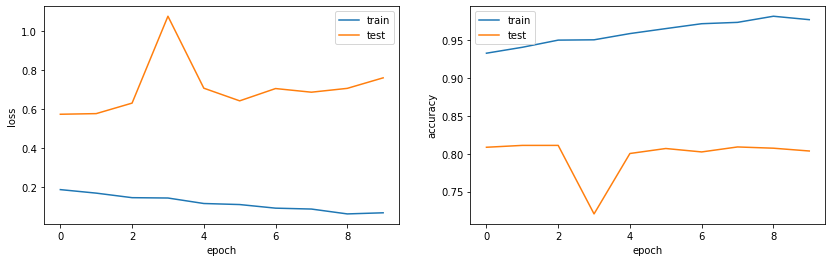

In [64]:
show_results_from_history(history2)

In [51]:
df_test = load_database_from_hdf(filename= base_dir / DEFAULT_DATABASE_NAME_TEST)
X_test = df_test["resized"]
X_test_eq_clahe = X_test.apply(lambda x: apply_equalization(x))
y_test = df_test["category"].map(category_mappings)

In [54]:
X_test_eq_clahe=np.stack(X_test_eq_clahe)

In [55]:
y_pred = model.predict(X_test_eq_clahe)
y_pred_classes = np.argmax(y_pred, axis = 1)

In [56]:
from sklearn.metrics import confusion_matrix

In [57]:
matrix = confusion_matrix(y_test, y_pred_classes)
matrix

array([[670, 102,  39],
       [ 79, 675,  57],
       [ 91,  88, 632]])

In [58]:
import seaborn as sns

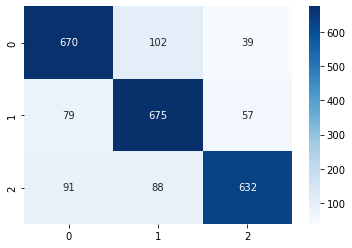

In [60]:
f = sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues")

In [61]:
class_acc = [matrix[i,i]/np.sum(matrix[i,:]) if np.sum(matrix[i,:]) else 0 for i in range(len(matrix))]
class_acc

[0.8261405672009864, 0.8323057953144266, 0.7792848335388409]

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

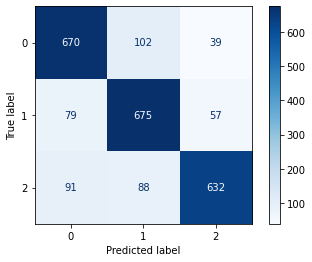

In [63]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, cmap=plt.cm.Blues)